Week 3 Project Problem 2

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [60]:
# Implement chol_psd()

def chol_psd(a):
    n = a.shape[0]  # get the size of the matrix

    root = np.zeros((n,n))  # initialize the root matrix with zeros

    for j in range(n):
        s = 0.0
        
        # calculate dot product of preceding row values if not on the first column
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])
        
        # calculate diagonal element
        temp = a[j,j] - s
        
        # check for small negative values and set to zero
        if temp <= 0 and abs(temp) < 1e-8:
            temp = 0.0
        
        root[j,j] = np.sqrt(temp)  # set the diagonal element
        
        # check for zero eigenvalue and set the rest of the column to zero
        if root[j,j] == 0.0:
            root[j,(j+1):n] = 0.0
        else:
            ir = 1.0 / root[j,j]  # calculate reciprocal of diagonal element
            for i in range(j+1,n):  # loop over remaining rows
                s = np.dot(root[i, :j], root[j, :j])
                root[i,j] = (a[i,j] - s) * ir  # update off-diagonal elements

    return root



In [61]:
# Implement near_psd()

def near_psd(a, epsilon=0.0):
    n = a.shape[0]  # get the size of the matrix

    invSD = None
    out = a.copy()

    # calculate the correlation matrix if we have a covariance
    if np.count_nonzero(np.isclose(np.diag(out), 1.0)) != n:
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD

    # SVD, update eigenvalues and scale
    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = 1.0 / (vecs ** 2 @ vals)
    T = np.sqrt(np.diag(T))
    l = np.sqrt(np.diag(vals))
    B = T @ vecs @ l
    out = B @ B.T

    # add back the variance
    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        out = invSD @ out @ invSD

    return out

In [62]:
# Generate a non-psd correlation matrix that is 500*500
n = 500
sigma = np.full((n,n), 0.9)
np.fill_diagonal(sigma, 1.0)
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

# make sure the resulting matrix is symmetric
sigma = (sigma + sigma.T) / 2

In [63]:
# The first projection for Higham method with the assumption that weight martrix is diagonal
def Pu(matrix):
    result = matrix.copy()
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if i==j:
                result[i][i]=1
    return result

# The second projection for Higham method
def Ps(matrix, weight):
    matrix = np.sqrt(weight)@ matrix @np.sqrt(weight)
    vals, vecs = np.linalg.eigh(matrix)
    vals = np.array([max(i,0) for i in vals])
    result = np.sqrt(weight)@ vecs @ np.diagflat(vals) @ vecs.T @ np.sqrt(weight)
    return result

def Frobenius_Norm(matrix_1, matrix_2):
    distance = matrix_1 - matrix_2
    result = 0
    for i in range(len(distance)):
        for j in range(len(distance)):
            result += distance[i][j]**2
    return result

# Implement Higham's method
def Higham_psd(matrix, weight = None, epsilon = 1e-9, max_iter = 1000, tolerance = 1e-8):

    if weight is None:
        weight = np.identity(len(matrix))
        
    norml = np.inf
    Yk = matrix.copy()
    Delta_S = np.zeros_like(Yk)
    
    invSD = None
    if np.count_nonzero(np.diag(Yk) == 1.0) != matrix.shape[0]:
        invSD = np.diag(1 / np.sqrt(np.diag(Yk)))
        Yk = np.matmul(np.matmul(invSD, Yk), invSD)
    
    Y0 = Yk.copy()

    for i in range(max_iter):
        Rk = Yk - Delta_S
        Xk = Ps(Rk, weight)
        Delta_S = Xk - Rk
        Yk = Pu(Xk)
        norm = Frobenius_Norm(Yk, Y0)
        minEigVal = np.real(np.linalg.eigvals(Yk)).min()
        if abs(norm - norml) < tolerance and minEigVal > -epsilon:
            break
        else:
            norml = norm
    
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        Yk = np.matmul(np.matmul(invSD, Yk), invSD)
    return Yk

In [64]:
# Use Higham's method to fix the matrix
sigma_fixed = Higham_psd(sigma)

# Use near_psd to fix the matrix 
sigma_fixed = near_psd(sigma_fixed)


In [65]:
# Test whether a matrix is psd or not
def is_psd(matrix):
    eigenvalues = np.linalg.eigh(matrix)[0]
    return np.all(eigenvalues >= -1e-8)

In [66]:
# Confirm the matrix is now PSD
print("Original matrix: ", is_psd(sigma))
print("Matrix fixed with near_psd(): ", is_psd(near_psd(sigma)))
print("Matrix fixed with Higham_psd(): ", is_psd(Higham_psd(sigma)))

Original matrix:  False
Matrix fixed with near_psd():  True
Matrix fixed with Higham_psd():  True


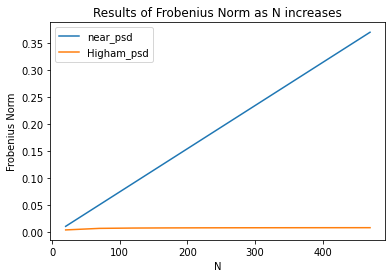

In [69]:
# Compare the results of both using the Frobenius Norm
n_range = np.arange(20, 500, 50)
frobenius_norms_near = []
frobenius_norms_higham = []
for n_current in n_range:
    sigma_current = sigma[:n_current, :n_current]
    sigma_fixed_near = near_psd(sigma_current)
    frobenius_norm_near = Frobenius_Norm(sigma_current, sigma_fixed_near)
    frobenius_norms_near.append(frobenius_norm_near)
    
    sigma_fixed_higham = Higham_psd(sigma_current)
    frobenius_norm_higham = Frobenius_Norm(sigma_current, sigma_fixed_higham)
    frobenius_norms_higham.append(frobenius_norm_higham)


plt.plot(n_range, frobenius_norms_near, label='near_psd')
plt.plot(n_range, frobenius_norms_higham, label='Higham_psd')
plt.xlabel('N')
plt.ylabel('Frobenius Norm')
plt.title('Results of Frobenius Norm as N increases')
plt.legend()
plt.show()

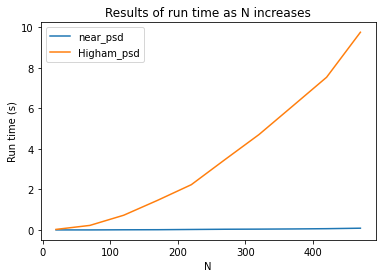

In [68]:
# Compare the run time between the two
n_range = np.arange(20, 500, 50)
time_near_psd = []
time_higham_psd = []
for n_current in n_range:
    sigma_current = sigma[:n_current, :n_current]
    
    start_time = time.time()
    sigma_fixed_near = near_psd(sigma_current)
    time_near = time.time() - start_time
    time_near_psd.append(time_near)
    
    start_time = time.time()
    sigma_fixed_higham = Higham_psd(sigma_current)
    time_higham = time.time() - start_time
    time_higham_psd.append(time_higham)

plt.plot(n_range, time_near_psd, label='near_psd')
plt.plot(n_range, time_higham_psd, label='Higham_psd')
plt.xlabel('N')
plt.ylabel('Run time (s)')
plt.title('Results of run time as N increases')
plt.legend()
plt.show()